# 0. Install and Import Dependencies

In [ ]:
!pip list

In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio
import dlib 

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

In [4]:
tf.config.experimental.get_memory_growth(physical_devices[0])  

True

# 1. Build Data Loading Functions

In [5]:

def load_video(video_path, display = False, output_path = False):   

    cap = cv2.VideoCapture(video_path)  

    face_detector = dlib.get_frontal_face_detector() 

    CROP_HEIGHT = 46 #input Parameter of the Model 
    CROP_WIDTH = 140 #imput Parameter of the Model

    FACE_HEIGHT = 0.5 

    lip_frames = [] 

    target_width = target_height = None 

    if output_path: 
        output_fourcc = cv2.VideoWriter_fourcc(*"MP4V")      
        output = cv2.VideoWriter(output_path, output_fourcc,cap.get(5), (CROP_HEIGHT, CROP_WIDTH))      

    while True:

        status, frame = cap.read() 
        
        if not status:
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) 
        faces = face_detector(gray) 

        if(len(faces)): 
            face = faces[0]   
            x, y, height, width = face.left(), face.top(), face.height(), face.width() 
            height = int(height*FACE_HEIGHT) 
            if(target_width is None or target_height is None):
                target_width = width  
                target_height = height 
            else:
                target_width = max(target_width, width) 
                target_height = max(target_height, height) 

            cropped_frame = cv2.resize(frame[y+height: y+(height*2), x: x+width], (target_width, target_height)) 
            cropped_frame = cv2.resize(cropped_frame, (CROP_WIDTH, CROP_HEIGHT))  
            cropped_frame = tf.image.rgb_to_grayscale(cropped_frame)     
            lip_frames.append(cropped_frame)  

        else:
            cropped_frame = np.zeros((CROP_WIDTH,CROP_HEIGHT,3))    

            # pass   

        if display:  
            try:    
                cv2.imshow("Lips", cropped_frame) 
                cv2.imshow("Normal",frame)  
            except Exception as e:
                print(e) 
                pass 

        if output_path:   
            output.write(cropped_frame)  

        if(cv2.waitKey(1) == ord('q')):
            break 

    cap.release() 
    cv2.destroyAllWindows()  

#processing Video Frames 

    mean = tf.math.reduce_mean(lip_frames)    
    std = tf.math.reduce_std(tf.cast(lip_frames, tf.float32))  

    processed = tf.cast(lip_frames - mean, tf.float32) / std 

    # return lip_frames  # Returns BGR IMAGE 
    # print(type(processed)) 

    # print(lip_frames) 
 

    # while True:
    #     for frame in processed.numpy():   
    #         cv2.imshow("Processed",frame)

    #     if cv2.waitKey(1) == ord('q'):
    #         break    

    # cv2.destroyAllWindows()          

    return processed 

In [6]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [7]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [8]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [9]:
char_to_num(['a','l','p','h','a']) 

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([ 1, 12, 16,  8,  1], dtype=int64)>

In [10]:
num_to_char([1, 12, 16,  8,  1]) 

<tf.Tensor: shape=(5,), dtype=string, numpy=array([b'a', b'l', b'p', b'h', b'a'], dtype=object)>

In [11]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [12]:
load_alignments("test.align")  

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39,  6, 39, 20, 23, 15,
       39, 14, 15, 23], dtype=int64)>

In [13]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    file_path = path.split("\\") 
    folder_name = path.split("\\")[-2] 
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join(".","GRID","data",folder_name,f'{file_name}.mpg')
    alignment_path = os.path.join(".","GRID",'alignments',folder_name,f'{file_name}.align') 
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [30]:
test_path = os.path.join(".","GRID","data", "s1","bbbf8p.mpg")   

In [31]:
test_path 

'.\\GRID\\data\\s1\\bbbf8p.mpg'

In [32]:
#test_path = "test_4.mp4" #'.\\GRID\\s1\\bbal6n.mpg'

In [33]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'bbbf8p'

In [34]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

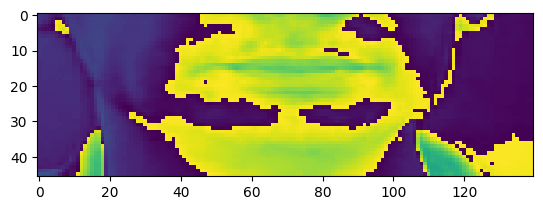

In [36]:
plt.imshow(frames[50])  

In [37]:
alignments

<tf.Tensor: shape=(26,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  2, 25, 39,  6, 39,  5,  9,  7,
        8, 20, 39, 16, 12,  5,  1, 19,  5], dtype=int64)>

In [38]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue by f eight please'>

In [39]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# 2. Create Data Pipeline

In [40]:
from matplotlib import pyplot as plt

In [41]:
data = tf.data.Dataset.list_files('./GRID/data/*/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
#data = data.apply(tf.data.experimental.ignore_errors()) 
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40])) # initial batch size 2
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split 
train = data.take(450)
test = data.skip(450).take(100)   

In [124]:
len(train) 

450

In [125]:
len(test)

100

In [126]:
frame, alignments= data.as_numpy_iterator().next() 

In [127]:
frame.shape 

(2, 75, 46, 140, 1)

In [42]:
frames, alignments = data.as_numpy_iterator().next()

In [43]:
alignments.shape 

(2, 40)

In [44]:
frames.shape 

(2, 75, 46, 140, 1)

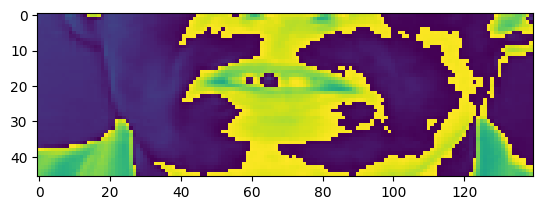

In [45]:
plt.imshow(frames[0][10]) 

In [132]:
frames.shape 

(2, 75, 46, 140, 1)

In [133]:
sample = data.as_numpy_iterator()

In [134]:
val = sample.next(); val[0]

array([[[[[ 2.002333  ],
          [ 1.8235532 ],
          [ 1.287214  ],
          ...,
          [ 0.67936295],
          [ 0.7508749 ],
          [ 0.7508749 ]],

         [[ 1.7877973 ],
          [ 1.9308211 ],
          [ 1.6090176 ],
          ...,
          [ 0.7151189 ],
          [ 0.7508749 ],
          [ 0.7508749 ]],

         [[ 2.1096008 ],
          [ 2.1096008 ],
          [ 1.6805295 ],
          ...,
          [ 0.7151189 ],
          [ 0.7151189 ],
          [ 0.7151189 ]],

         ...,

         [[ 6.0427547 ],
          [ 6.114267  ],
          [ 6.4003143 ],
          ...,
          [ 9.117766  ],
          [ 9.08201   ],
          [ 9.010498  ]],

         [[ 6.006999  ],
          [ 6.2572904 ],
          [ 6.6506057 ],
          ...,
          [ 8.903231  ],
          [ 8.938987  ],
          [ 8.867475  ]],

         [[ 6.0785108 ],
          [ 6.4003143 ],
          [ 6.9008975 ],
          ...,
          [ 8.366891  ],
          [ 8.652939  ],
          

In [135]:
val[0][0].shape 

(75, 46, 140, 1)

In [37]:
import array2gif 

In [38]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video 
#array2gif.write_gif(val[0][0][10:],"./animation.gif", fps = 5) 

In [136]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue by z eight soon'>

# 3. Design the Deep Neural Network

In [46]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard

In [138]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [47]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [48]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128)  3584      
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                    

In [49]:
5*17*75

6375

In [50]:
model.load_weights("improve_model/checkpoint")  

In [51]:
frames, alignments = data.as_numpy_iterator().next() 

In [52]:
frames.shape 

(2, 75, 46, 140, 1)

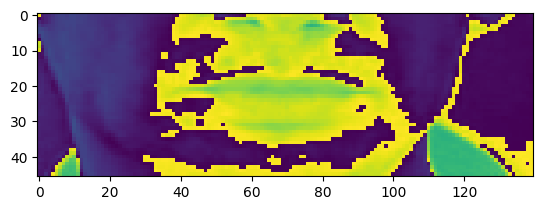

In [53]:
plt.imshow(frames[0][10]) 

In [57]:
frames.shape 

(2, 75, 46, 140, 1)

In [58]:
yhat = model.predict(frames)  

1/1 [==============================] - 5s 5s/step


In [60]:
type(yhat) 

numpy.ndarray

In [61]:
yhat.shape 

(2, 75, 41)

In [ ]:
yhat[0][0] 

In [147]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'set   blue   by   u   tine   ppleeasee'>

In [148]:
tf.strings.reduce_join(num_to_char(alignments[0]))    

<tf.Tensor: shape=(), dtype=string, numpy=b'set sp blue by a nine please'>

In [149]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in alignments])

<tf.Tensor: shape=(), dtype=string, numpy=b'cc'>

In [150]:
model.input_shape

(None, 75, 46, 140, 1)

In [151]:
model.output_shape

(None, 75, 41)

# 4. Setup Training Options and Train

In [152]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [153]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [154]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [155]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)   # initial learning rate 0.0001  

In [156]:
checkpoint_callback = ModelCheckpoint(os.path.join('new_try_model','checkpoint'), monitor='loss', save_weights_only=True) 

In [157]:
schedule_callback = LearningRateScheduler(scheduler)

In [158]:
example_callback = ProduceExample(test)

In [ ]:
tensorboard_callback = TensorBoard(log_dir = "./logs", histogram_freq = 1)  

In [159]:
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback]) 

Epoch 1/100
1/1 [==============================] - 1s 1s/steps - loss: 23.54
Original: set green by v seven now
Prediction: set red by p seve now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place green by q nine now
Prediction: place red it c fero nown
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 4368s 10s/step - loss: 23.5478 - val_loss: 17.7920 - lr: 1.0000e-04
Epoch 2/100
1/1 [==============================] - 0s 446ms/step loss: 21.62
Original: bin blue by s three now
Prediction: bin blue wiy o zire now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay red in k four again
Prediction: lay gren it q five again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 3002s

KeyboardInterrupt: 

# 5. Make a Prediction 

In [ ]:
import gdown 

In [ ]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

In [110]:
model.load_weights('improve_model/checkpoint')

In [111]:
#test_data = test.as_numpy_iterator()

In [112]:
#sample = test_data.next()

In [62]:
sample = data.as_numpy_iterator().next() 

In [68]:
np.array(sample[1]).shape 

(2, 40)

In [73]:
yhat = model.predict(tf.expand_dims(sample[0][0],axis = 0)) 

1/1 [==============================] - 0s 470ms/step


In [74]:
yhat.shape

(1, 75, 41)

In [115]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'set red with v three again'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay red by e five soon'>]

In [116]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [117]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'set redn with v sivee again'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay whie bt five soon'>]

# Test on a Video

In [75]:
sample = load_data(tf.convert_to_tensor('.\\data\\s1\\bras9a.mpg'))

In [76]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]

In [77]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 0s 354ms/step


In [79]:
yhat.shape 

(1, 75, 41)

In [121]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [122]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bia gree bt sive again'>]